In [4]:
from Models.GlassBox.ebm.ebm_class import EBM_class
from InterpretabilityByDesign.EBM_Interpreter import ExplainableBMInterpreter
import matplotlib.pyplot as  plt
import seaborn as sns
import pandas as pd

sns.set_style("darkgrid")
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
%reload_ext autoreload
%autoreload 2

In [5]:
EBM_parameter = dict(
    learning_rate= [0.005, 0.01, 0.02, 0.03],
    min_samples_leaf=[2, 3, 4, 5],
    max_leaves=[2, 3, 4],
    max_bins=[5, 7, 10],
    outer_bags=[8, 10],
)
gridsearch_parameters = dict(
    path="./../../../outputs/scores/",
    name="0",
    nDCG_at=15
)

# Grid-search

In [6]:
gs = EBM_class(**gridsearch_parameters)

In [4]:
best_ = gs.grid_search(hyperparameters=EBM_parameter)
gs.save_model(best_[0], name="EBMReg")

Finding the best model: 100%|██████████| 288/288 [15:42<00:00,  3.27s/it, nDCG_15_at=0.983]


# Metric evaluation

In [7]:
best_model = gs.load_model(name="./saved_models/EBMReg")

In [8]:
# nDCG on test-set
nDCG_train = gs.eval_model(model=best_model, df=gs.train, nDCG_at=[1,10,15])
nDCG_valid = gs.eval_model(model=best_model, df=gs.valid, nDCG_at=[1,10,15])
nDCG_test = gs.eval_model(model=best_model, df=gs.test, nDCG_at=[1,10,15])

display(pd.DataFrame([nDCG_train,nDCG_valid,nDCG_test],index=["Training","Validation","Test"]))

,nDCG@1,nDCG@10,nDCG@15
Training,0.9361,0.9597,0.9674
Validation,0.9376,0.9757,0.9825
Test,0.9270,0.9647,0.9735


# Explanation

In [9]:
unique_values = {
    'fitness_edu_basic':[0, 1],
    'fitness_edu_bonus':[0, 1],
    'fitness_city':[0, 0.5, 1],
    'fitness_age':[0, 1],
    'fitness_exp_basic':[0,1],
    'fitness_exp_bonus':[0,1],
    'fitness_lang_basic':[0, 0.5, 1],
    'fitness_lang_lvl_basic':[0, 0.5, 1],
    'fitness_lang_bonus':[0, 0.5, 1],
    'fitness_comp_basic':[0, 0.25, 0.33, 0.5, 0.66, 0.75, 1],
    'fitness_comp_sim_basic':[0, 0.25, 0.5 , 0.75, 1],
    'fitness_comp_bonus':[0, 0.33, 0.5, 0.66, 1],
    'fitness_comp_sim_bonus':[0, 0.25, 0.5 , 0.75, 1],
    'fitness_know_basic':[0, 0.25, 0.33, 0.5, 0.66, 0.75, 1],
    'fitness_know_sim_basic':[0, 0.25, 0.5 , 0.75, 1],
    'fitness_know_bonus':[0, 0.33, 0.5, 0.66, 1],
    'fitness_know_sim_bonus':[0, 0.25, 0.5 , 0.75, 1]
}

In [13]:
interpreter = ExplainableBMInterpreter.build(best_model,unique_values,"saved_models/EBM_Interpreter")

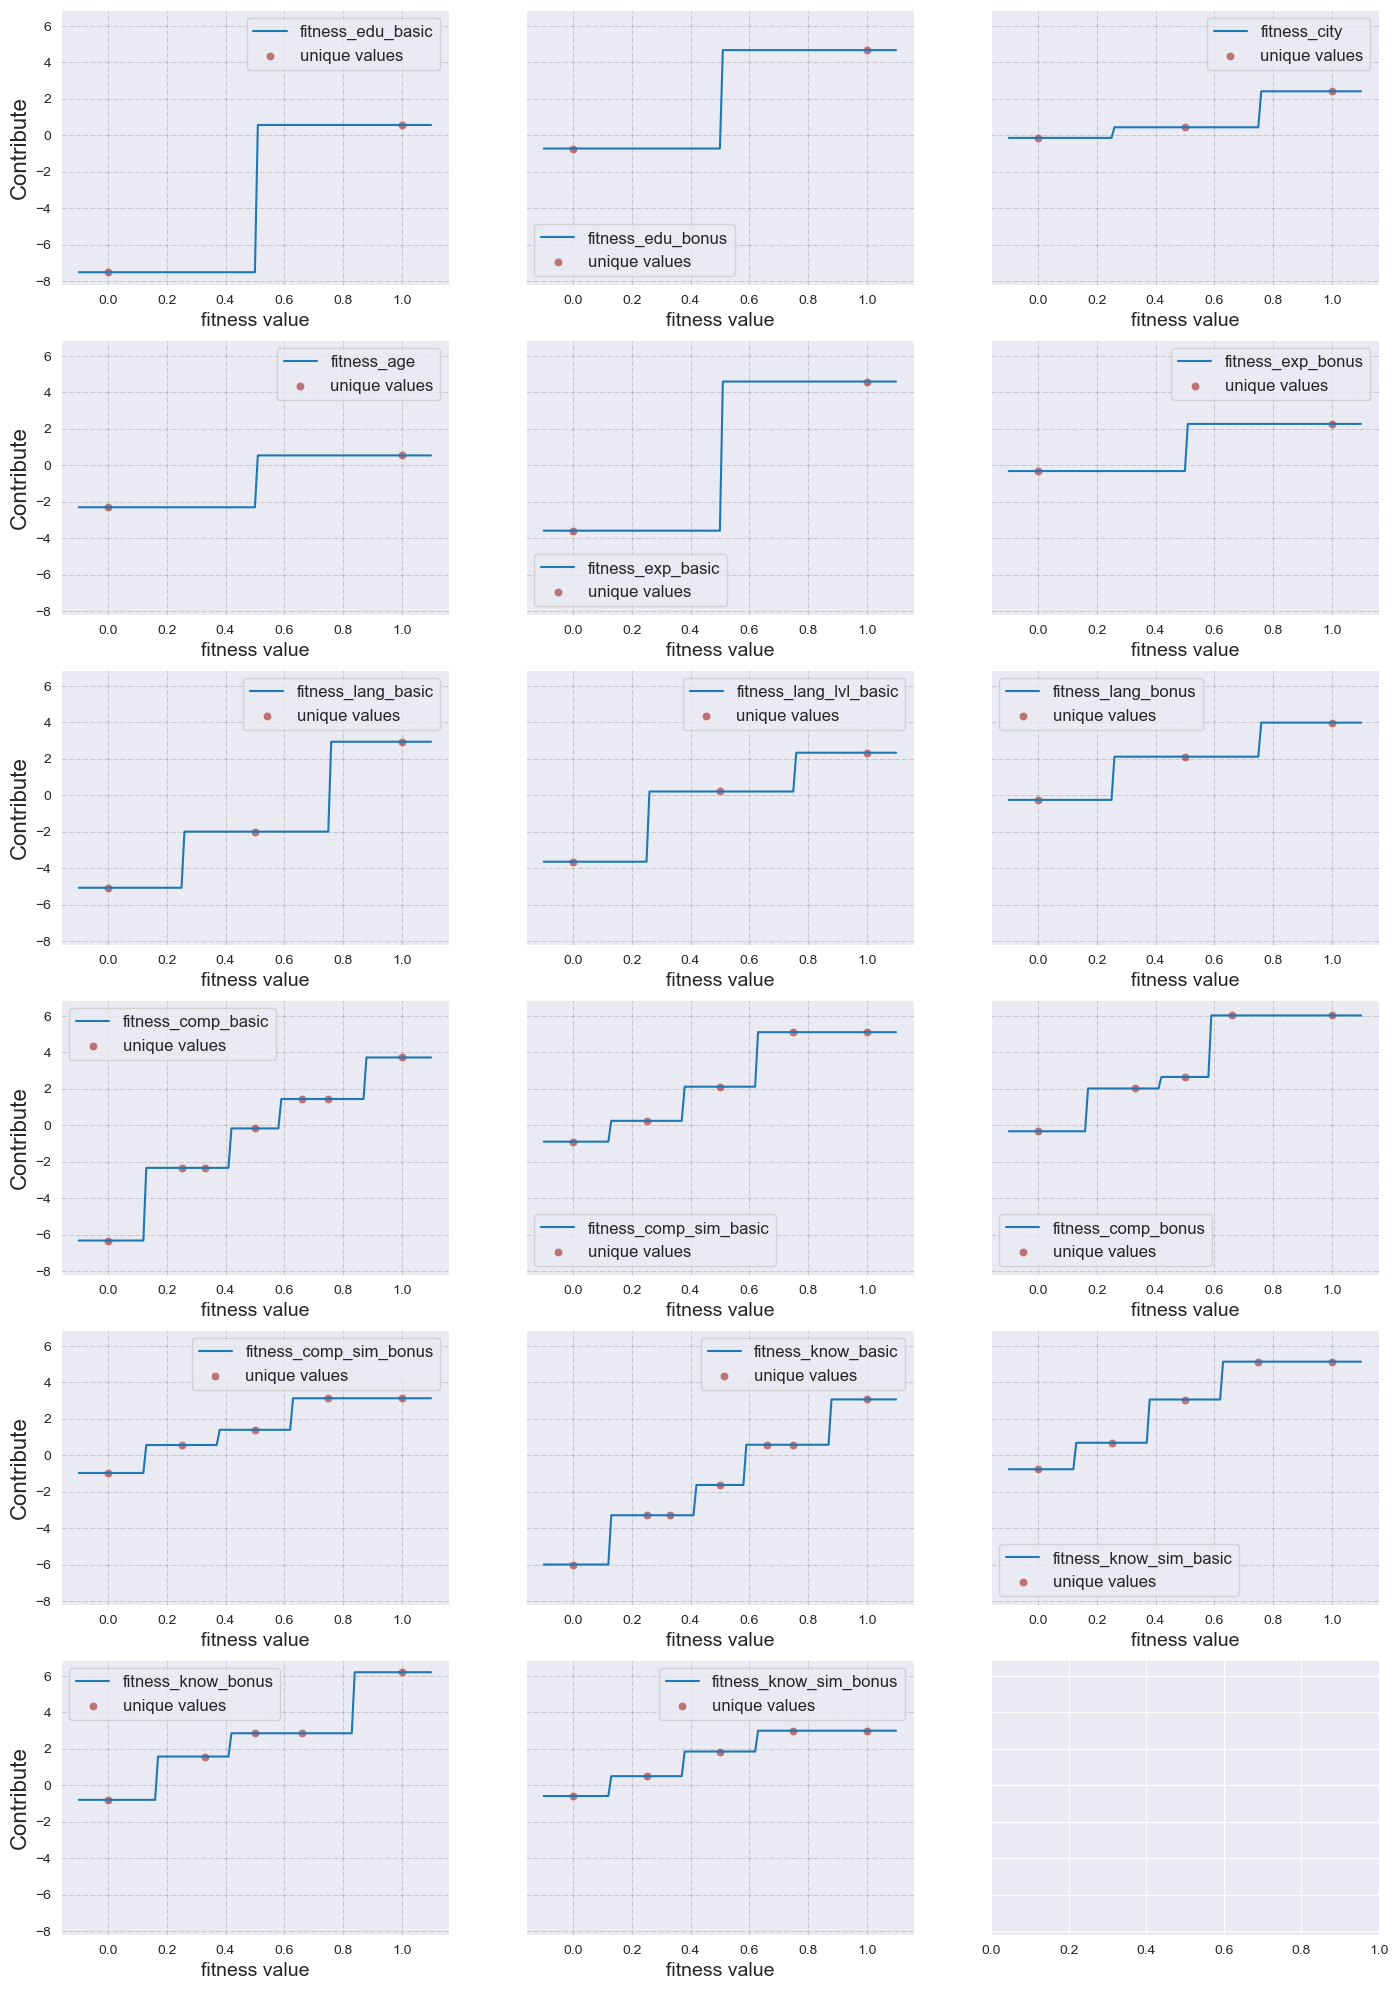

In [26]:
f, axs = plt.subplots(ncols=3,nrows=6,figsize=(17, 25), sharey=True)
for i, feature, in enumerate(interpreter.get_features()):
    fun = interpreter.get_piecewise_function(feature)
    points = interpreter.build_dataframe_function(feature)
    sns.lineplot(x="x",y="y",data=fun, label=feature, ax=axs[int(i/3)][i%3])
    sns.scatterplot(x="x",y="y",data=points, ax=axs[int(i/3)][i%3], color="#8B0000",  alpha=0.5, label="unique values")
    # axs[int(i/3)][i%3].fill_between(fun['x'], fun['lower'], fun['upper'], color='#4B4BFF', alpha=0.3)
    axs[int(i/3)][i%3].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
    axs[int(i/3)][i%3].set_xlabel("fitness value", fontsize=14)
    axs[int(i/3)][i%3].set_ylabel("Contribute", fontsize=16)
    axs[int(i/3)][i%3].legend(fontsize=12)
plt.show()